# MUST RUN IN JUPYTER NOTEBOOK - RUN COMMAND "jupyter notebook quality_control.ipynb"

# BEFORE RUNNING:
## Create a onetime copy of the original JSON you will be using and use that as path. Otherwise changes will be irreversible

## If running for the FIRST TIME: uncomment #create_csv() in line 35 in the 3rd code cell. this will create a checkpoint csv to save your spot. BE SURE TO RECOMMENT OUT.

In [1]:
from IPython.display import HTML, IFrame, clear_output, YouTubeVideo
import json
import time
import pandas as pd
import time
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())
from supabase import create_client
from datetime import date
from google.cloud import storage
from pytube import YouTube
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip

In [2]:
# Connect to database
url = os.environ.get("SUPABASE_URL")
key = os.environ.get("SUPABASE_KEY")
email = os.environ.get("EMAIL")
password = os.environ.get("PASSWORD")
client = create_client(url, key)
user = client.auth.sign_in(email=email, password=password)

# connect to gcloud bucket
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'survai-data-connect.json'
storage_client = storage.Client()
bucket_name = 'survai-dataset'
bucket = storage_client.bucket(bucket_name)

In [3]:
var_data = 'test_var_data'
urls = 'test_urls'

# if clarity_level is not none, set reviewed to yes
clarity_list = list(client.table(var_data).select('index', 'clarity_level', 'id', 'reviewed', 'label', 
                                                   'time_start', 'time_end', 'youtube_id').execute())[0][1]


#for i in clarity:
#   if i['clarity_level'] != 'none':
#      client.table(var_data).update({'reviewed': 'yes'}).eq('id', i['id']).execute()


"for i in clarity:\n   if i['clarity_level'] != 'none':\n      client.table(var_data).update({'reviewed': 'yes'}).eq('id', i['id']).execute()"

In [4]:
def play_vid(html):
    display(IFrame(html, width=560, height=315))

would you like to do quality control by label or by index?: index
enter the specific index number you would like to start from: 38


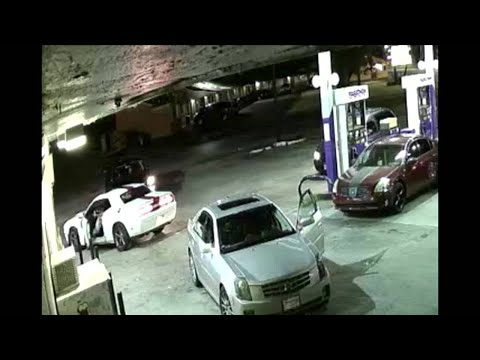

In [8]:
choice = input('would you like to do quality control by label or by index?: ')

if choice == 'label': 
    label = input('enter the label you wish to perform quality control on: ')
    index = None

if choice == 'index': 
    index = int(input('enter the specific index number you would like to start from: '))
    label = None

for i in clarity_list:
    id = i['id']
    start = i['time_start']
    end = i['time_end']
    yt_id = i['youtube_id']

    if i['reviewed'] == None:
        
        if i['label'] == label or i['index'] == index:

            # display video    
            video = YouTubeVideo(yt_id, width=560, height=315, start=start, end=end)
            display(video)
        

In [ ]:
def play_vid(html):
    display(HTML(html))
    
def save_changes(json_object, vid_id, new_start, new_end, tags):
    
    # save vid segment changes
    json_object[vid_id]['annotations']['segment'][0] = new_start
    json_object[vid_id]['annotations']['segment'][1] = new_end
    json_object[vid_id]['duration'] = new_end - new_start
    json_object[vid_id]['tags'] = tags
    
    #overwrite json object with changes
    with open(JSON_PATH, 'w') as outfile:
        json.dump(json_object, outfile)
    
    #checkpoint save spot into csv
    json_label = json_object[vid_id]['annotations']['label']
    df.at[json_label, 'last_id'] = vid_id
    df.to_csv('qc_checkpoints_donotdelete.csv')
        
        
def create_csv():
    "ONLY MEANT TO BE RAN ONCE, OR WHEN NEW LABEL IS CREATED"
    
    df = pd.DataFrame(columns=['label', 'last_id'])
    
    for key in data.keys():
        if data[key]['annotations']['label'] not in df['label'].unique():
            row = {'label': data[key]['annotations']['label'], 'last_id': None}
            df = df.append(row, ignore_index=True)
    df = df.set_index('label')
    df.to_csv("qc_checkpoints_donotdelete.csv")
    print(df)

    """IF RUNNING FOR THE FIRST TIME, UNCOMMENT THE FOLLOWING CODE. 
    
    !!!IMMEDIATELY RECOMMENT OUT AFTER USE!!!
    """
#create_csv()

In [ ]:
initial_input = input("type label (case sensitive) you want to go through.")
selected_label = initial_input.split(" ")[0]
breakout = False

all_label_ids = []

# create list of all keys with matching labels if not bad egg
for key in data.keys():
    if data[key]['annotations']['label'] == selected_label:
        if data[key]['tags']['bad_egg'] == False:
            all_label_ids.append(key)
        else:
            continue
            
# find spot left off at
for i, vid_id in enumerate(all_label_ids):
    
    # if vid id is same as checkpoint
    if vid_id == df.at[selected_label, 'last_id']:
        starting_index = i
        break
    else: 
        starting_index = 0


        
        
# iterate all videos
while True:
    
    key = all_label_ids[starting_index]
    
 
    key_str = key[:11]
    start = int(data[key]['annotations']['segment'][0])
    end = int(data[key]['annotations']['segment'][1])
    duration = int(data[key]['duration'])
    label = data[key]['annotations']['label']
    tags= data[key]['tags']
    cl_tag = data[key]['tags']['clarity_level']
    be_tag = data[key]['tags']['bad_egg']
    adjusting_annot = True
    is_changing = False
    
    
    if breakout == True:
        text_file = open("log_records.txt", "r").read()
        print(text_file)
        time.sleep(3)
        clear_output() 
        break
        
    if cl_tag != '':
        untagged = False
    else:
        untagged = True 
        
        
    #iterate same video until ready
    while adjusting_annot == True:
            
        clear_output(wait=True) 
        html = f'<iframe width="560" height="315" \
            src="https://www.youtube.com/embed/{key_str}?autoplay=1&start={start}&end={end}&loop=1" \
            title="YouTube video player" \
            frameborder="0" \
            allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" \
            allowfullscreen></iframe>'
        play_vid(html)
        if be_tag == True:
            print("BADEGG BADEGG BADEGG BADEGG BADEGG BADEGG BADEGG BADEGG")
        if is_changing == True:
            print(f"index:{starting_index}/{len(all_label_ids)}","label:", label, "start:", start, "end:", end, f"original:{int(data[key]['annotations']['segment'][0])} - {int(data[key]['annotations']['segment'][1])}", "tag:", cl_tag)
        else:
            print(f"index:{starting_index}/{len(all_label_ids)}", "label:", label, "start:", start, "end:", end, "tag:", cl_tag)
        time.sleep(1)
        

        
        input_step_2 = input("r=restartvid, (s or e)(num)=change start or end time,xxx=badegg(delete), xxxr=reversedelete, cl (e,m,h)=claritylevel, exit=exit")
        
        # restart video
        if input_step_2 == 'r':
            continue
            
        # if changing start value    
        if 's' in input_step_2 and len(input_step_2) > 1 and len(input_step_2) < 4:
            is_changing = True
            change_int = int(input_step_2[1:])
            
            if start + change_int >= 0:
                start += change_int
                continue
            else:
                print("ayo?")
                time.sleep(5)
                continue

        # if changing end value
        print(len(input_step_2))
        if 'e' in input_step_2 and len(input_step_2) > 1 and len(input_step_2) < 4:
            is_changing = True
            change_int = int(input_step_2[1:])
            end += change_int
            continue
                
        # delete annotation
        if input_step_2 == "xxx":
            data[key]['tags']['bad_egg'] = True
            be_tag = data[key]['tags']['bad_egg']
            untagged = False
            
        if input_step_2 == "xxxr":
            data[key]['tags']['bad_egg'] = False
            be_tag = data[key]['tags']['bad_egg']
              
        # tag video
        if "cl" in input_step_2:
            command = input_step_2.split(" ")[1]
            if command == 'e':
                data[key]['tags']['clarity_level'] = 'easy'
                cl_tag = data[key]['tags']['clarity_level']
                untagged = False
            elif command == 'm':
                data[key]['tags']['clarity_level'] = 'medium'
                cl_tag = data[key]['tags']['clarity_level']
                untagged = False
            elif command == 'h':
                data[key]['tags']['clarity_level'] = 'hard'
                cl_tag = data[key]['tags']['clarity_level']
                untagged = False
            else:
                html = f'<iframe width="560" height="315" \
                src="https://www.youtube.com/embed/D2_r4q2imnQ?autoplay=1&loop=1" \
                title="YouTube video player" \
                frameborder="0" \
                allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" \
                allowfullscreen></iframe>'
                play_vid(html)
                time.sleep(5)
                continue
                
                
        # if going to next video  
        if input_step_2 == 'n':
            save_changes(data, key, start, end, tags)
            if untagged == True:
                print('no tag on video')
                time.sleep(3)
                continue
            else:
                starting_index += 1
                adjusting_annot = False
            
        # if going to previous video  
        if input_step_2 == 'p':
            save_changes(data, key, start, end, tags)
            starting_index -= 1
            adjusting_annot = False
                
        #exit app
        if input_step_2 == 'exit':
            save_changes(data, key, start, end, tags)
            breakout = True
            break
            
            
